## Explore Dataset -- Data Exploration and Insights Extraction

This notebook aims to explore the dataset -- limited to the training dataset -- to understand the data available and extract insights that might be relevant for the model creation.


### Tasks:
 - [X] Load training dataset.
 - [X] Understand columns (including target):
     - [X] Values range and distribution.
     - [X] Missing values.
     - [X] Columns relationship with labels.
 - [X] Identify pre-processing operations needed.
 - [X] Identify potential features and transformations.


### Dataset Columns

According to the [dataset documentation](https://www.kaggle.com/datasets/sufyant/brazilian-real-bank-dataset), the meaning of each columns is:

 - `id`: id
 - `celular`: phone number
 - `safra_abertura`: branch number
 - `cidade`: city
 - `estado`: state
 - `idade`: age
 - `sexo`: gender
 - `limite_total`: total credit card limit
 - `limite_disp`: current available limit
 - `data`: date
 - `valor`: amount
 - `grupo_estabelecimento`: category of expense 
     - `SERVIÇO`: any service other than restaurants
     - `FAMARCIAS`: drugstores
     - `M.O.T.O`: online purchases
     - `ARTIGOS ELETRO`: electronics
     - `VAREJO`: convenience store
     - `LOJA DE DEPART`: department store
     - `VESTUARIO`: clothing
     - `HOSP E CLINICA`: hospital or clinic
     - `SEM RAMO`: not specified/other expenses
     - `SUPERMERCADOS`: supermarket
     - `MAT CONSTRUCAO`: construction material
     - `POSTO DE GAS`: gas station
     - `RESTAURANTE`: restaurant
     - `CIA AEREAS`: airlines
     - `MOVEIS E DECOR`: furniture & decoration
     - `JOALHERIA`: jewelry
     - `TRANS FINANC`: financial transfers
     - `AGENCIA DE TUR`: tourism agency
     - `HOTEIS`: hotels
 - `cidade_estabelecimento`: city where the purchase was made
 - `pais_estabelecimento`: country where the purchase was made
 
 The column `celular`, however, was not found. Maybe it was removed due to privacy concerns. 

## Libraries and Configurations

In [1]:
from datetime import datetime
from typing import List, Dict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML

from application.code.core.configurations import configs
from application.code.adapters.storage import read_dataset
from application.code.core.feature_engineering import (clean_column_names,
                                                       change_column_types,
                                                       format_string_columns, 
                                                       standardize_labels,
                                                       engineer_features)

sns.set_style("whitegrid")

## Constants

In [2]:
NUMERIC_COLUMNS = ['safra_abertura',  'idade',
                   'limite_total', 'limite_disp', 'valor']

CATEGORICAL_COLUMNS = ['id', 'cidade', 'estado', 'sexo', 'data',
                       'grupo_estabelecimento', 'cidade_estabelecimento',
                       'pais_estabelecimento']

## Local Functions

In [3]:
def count_missing_values(df: pd.DataFrame) -> List[Dict[str, int]]:

    missing_values = []

    for column in df.columns:

        columns_missing_values = len(df[lambda f: f[column].isna() |
                                       f[column].apply(lambda col: (len(str(col).strip()) == 0) or (str(col) == '-'))])

        missing_values.append({'column': column, 
                               'missing_values': columns_missing_values})
        
       
    return missing_values

## Load Dataset

The `training` dataset is loaded to allow the analysis.

In [4]:
df = read_dataset(base_path=configs.datasets.base_path, stage='raw', file_name='train')

print(f'Records: {len(df)}')

print('\nSample (transposed to provide a better view):')
df.head(3).T

Records: 3944

Sample (transposed to provide a better view):


,0,1,2
id,"4,53E+11","4,53E+11","4,53E+11"
safra_abertura,201405,201405,201405
cidade,CAMPO LIMPO PAULISTA,CAMPO LIMPO PAULISTA,CAMPO LIMPO PAULISTA
estado,SP,SP,SP
idade,37,37,37
sexo,F,F,F
limite_total,4700,4700,4700
limite_disp,5605,5343,2829
data,4.12.2019,9.11.2019,6.05.2019
valor,31,"150,01",50


## Check Duplicates

There are two records with repeated content in the dataset. Even though the number is not high, the values will be removed as part of the cleaning. 
From the point of view of a model training, it is not interesting to repeat the data, as the record will increase its importance for the learning process.

In [5]:
print(f'Original records:\t{len(df)}')
print(f'Deduplicated records:\t{len(df.drop_duplicates())}')

redundant_records_df = (
    df
    .loc[lambda f: ~f.index.isin(set(df.drop_duplicates().index))]
)

print('\nRedundant records:')
redundant_records_df

Original records:	3944
Deduplicated records:	3942

Redundant records:


,id,safra_abertura,cidade,estado,idade,sexo,limite_total,limite_disp,data,valor,grupo_estabelecimento,cidade_estabelecimento,pais_estabelecimento,period
3288,"6,51E+11",201705,SAO PAULO,SP,27,M,3650,3783,18.07.2019,"6,53",SERVIO,SAO PAULO,BR,2019-07-18
3307,"6,51E+11",201705,SAO PAULO,SP,27,M,3650,2665,1.08.2019,"5,55",SERVIO,SAO PAULO,BR,2019-08-01


### Basic Dataset Preprocessing

During the analysis some basic transformations and fixes were identified. To avoid dealing with the issues along the notebook, the most basic ones will be performed in this section.

In [6]:
df = (
    df
    .drop_duplicates()
    .pipe(clean_column_names)
    .pipe(change_column_types)
    .pipe(format_string_columns, columns=CATEGORICAL_COLUMNS)
    .pipe(standardize_labels)
)

## Exploratory Data Analysis

### Columns Summary

In [7]:
display(HTML('<h4>Numeric Columns</h4>'))
display(df[NUMERIC_COLUMNS].describe(include='all'))

display(HTML('<h4>Categorical Columns</h4>'))
display(df[CATEGORICAL_COLUMNS].describe(include='all'))

,safra_abertura,idade,limite_total,limite_disp,valor
count,3942.000000,3942.000000,3942.000000,3942.000000,3931.000000
mean,201681.916794,33.822425,8242.897514,6328.174023,103.181717
std,225.741436,6.857333,9927.134503,9822.805192,393.794661
min,201008.000000,20.000000,300.000000,0.000000,0.270000
25%,201602.000000,28.000000,3650.000000,1082.000000,13.295000
50%,201710.000000,33.000000,4700.000000,2676.500000,30.000000
75%,201901.000000,36.000000,7500.000000,6012.750000,81.355000
max,201910.000000,53.000000,40000.000000,42289.000000,10602.000000


,id,cidade,estado,sexo,data,grupo_estabelecimento,cidade_estabelecimento,pais_estabelecimento
count,3942,3942,3942,3942,3942,3942,3942,3942
unique,28,10,2,2,301,21,115,8
top,"5,02e+11",sao paulo,sp,f,10.08.2019,serviço,sao paulo,br
freq,587,2958,3732,2097,32,1453,2622,3912


#### Categorical Columns Detailing

This section explores the categorical values from columns. When there are more then 10 distinct values for a column, an scroll is enabled and the background color is set to blue.

In [8]:
for column in CATEGORICAL_COLUMNS:
    
    distinct_values = sorted(df[column].dropna().unique().tolist())
    serialized_values = ''.join([f'<li>{value}</li>' for value in distinct_values])
    
    display(HTML(f'<strong>{column} - {len(distinct_values)}</strong>'))
    
    if len(distinct_values) > 10:
        style = style=("style='height:250px;width:500px;"
                       "overflow:scroll;background-color:#d4e6f1;'")
    else:
        style = ''
    
    display(HTML(f'''
    <div {style}>
        <ul>{serialized_values}</ul>
    </div>
    '''))

Detailing the cases where `pais_estabelecimento` is not `br` and `cidade` is in `cidade_estabelecimento`.

In [9]:
brazilian_cities = set(df['cidade'].tolist())

(
    df
    .loc[lambda f: (f['cidade_estabelecimento'].isin(brazilian_cities)) & 
                   (f['pais_estabelecimento'] != 'br')]
)

,id,safra_abertura,cidade,estado,idade,sexo,limite_total,limite_disp,data,valor,grupo_estabelecimento,cidade_estabelecimento,pais_estabelecimento,period
3377,64831300521,201008,itaquaquecetuba,sp,51,m,1420,580,23.01.2020,NaN,varejo,sao paulo,sp,2020-01-23


About categorical values, it is possible to identify that:
 - `cidade` and `estado`, which are users' location, have a limited and consistent number of values.
 - `cidade_estabelecimento` and `pais_estabelecimento` are more diversified and present some inconsistent values, such as `11001bogota` and `415-503-9235`. Some of those values might be recorded for the wrong column, such as `5,51e+11`. Also, both of them present missing values. 
 - `grupo_estabelecimento`, which is the label to be learned and predicted, is consistent.

Some approaches that could be performed to improve the dataset quality:
 - Infer inconsistent values based users' transactions performed in a limited period of time.
 - Use a map of cities, states and countries to validate and infer values.

 
Due to the time limit to conduct this project and the potentially negligible number of records, no treatment will be performed initially.

### Missing Values

This section checks, for each column, the number of missing values (e.g., `na`, `nan`, `''`, and `-`).

In [10]:
missing_values = count_missing_values(df)

(
    pd.DataFrame(missing_values)
    .sort_values(by=['missing_values', 'column'], ascending=[False, True])
)

,column,missing_values
11,cidade_estabelecimento,11
9,valor,11
12,pais_estabelecimento,10
2,cidade,0
8,data,0
3,estado,0
10,grupo_estabelecimento,0
0,id,0
4,idade,0
7,limite_disp,0


As there are three columns with missing values, the incomplete records will be checked.

In [11]:
df_slice = df.loc[lambda f: f['pais_estabelecimento'].isna() | 
                            f['cidade_estabelecimento'].isna() | 
                            f['valor'].isna()]

print(f'Records with missing values: {len(df_slice)} ({len(df_slice) / len(df) * 100:.2f}%)')
df_slice

Records with missing values: 11 (0.28%)


,id,safra_abertura,cidade,estado,idade,sexo,limite_total,limite_disp,data,valor,grupo_estabelecimento,cidade_estabelecimento,pais_estabelecimento,period
572,94873707154,201710,sao paulo,sp,32,f,2200,628,12.05.2019,NaN,transação financeira,,,2019-05-12
629,94873707154,201710,sao paulo,sp,32,f,2200,9,10.09.2019,NaN,transação financeira,,,2019-09-10
868,"5,02e+11",201901,sao paulo,sp,34,f,5750,1012,27.12.2019,NaN,transação financeira,,,2019-12-27
1123,"5,02e+11",201901,sao paulo,sp,34,f,3400,110,13.08.2019,NaN,transação financeira,,,2019-08-13
1166,"5,02e+11",201901,sao paulo,sp,34,f,4000,934,19.10.2019,NaN,transação financeira,,,2019-10-19
1170,"5,02e+11",201901,sao paulo,sp,34,f,4000,333,22.10.2019,NaN,transação financeira,,,2019-10-22
2738,"5,02e+11",201901,sao paulo,sp,34,f,5200,36,27.08.2019,NaN,transação financeira,,,2019-08-27
2759,"5,02e+11",201901,sao paulo,sp,34,f,5200,2004,10.11.2019,NaN,transação financeira,,,2019-11-10
2767,"5,02e+11",201901,sao paulo,sp,34,f,6500,955,31.08.2019,NaN,transação financeira,,,2019-08-31
2983,"8,14e+11",201705,sao paulo,sp,28,m,4700,2102,12.04.2019,NaN,transação financeira,,,2019-04-12


About missing values, it is possible to observe:
 - The number of missing values 12 is not a problem in terms of training a model, as it only influences 0.3% of the data.
 - All missing values from `pais_estabelecimento` are also missing in `cidade_estabelecimento`. Maybe `cidade` and `estado` can be used to infer the missing values.
 - Missing values for column `valor` are also highly related to missing values on `establishment` columns. It might be a quality from the organization responsible for sending the data.
 
 The presence of missing values on training might be an indicative that production data might also have missing values. It would be interesting to know what to do in terms of product. Some options are:
 - Do not use features with missing values.
 - Do not classify data with missing values.
 - Perform generic data imputation for missing values.
 - Use data from a recent user's history to infer the location (using some time distance threshold).
 - Use an algorithm that deals with missing values.

### Label Analysis

This sections analyzes labels. The first verification is the distribution of them.

#### Distribuition

In [12]:
labels_records_df = (
    df
    [['grupo_estabelecimento']]
    .assign(records=1)
    .groupby('grupo_estabelecimento')
    .sum()
    .reset_index() 
    .sort_values(by='records', ascending=False)
    .assign(percentage=lambda f: (f['records'] / f['records'].sum()).apply(lambda p: f'{p * 100:.2f}%'))
)

labels_records_df

,grupo_estabelecimento,records,percentage
16,serviço,1453,36.86%
14,restaurante,708,17.96%
19,varejo,447,11.34%
17,supermercados,377,9.56%
20,vestuário,197,5.00%
6,farmácias,165,4.19%
13,posto de gás,158,4.01%
5,compra online,142,3.60%
2,artigos eletro,95,2.41%
10,loja de departamento,64,1.62%


As the table presents, the dataset is very unbalanced, with labels varying from about 1400 records (~37%) to just 1 (0.03%).

From the 21 labels, 11 have less than 1% of the number of the dataset records. That might impose a challenge to be able to make predictions.

For a real products, the rare labels could be avoided or grouped into a more general label to at least provide a better segment for the records.

#### Values Distribution

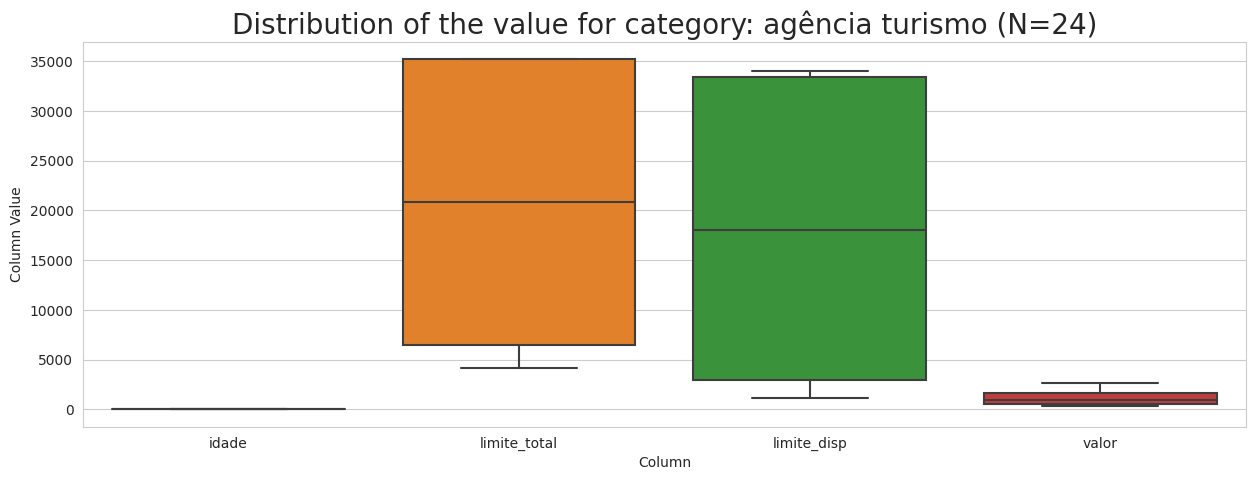

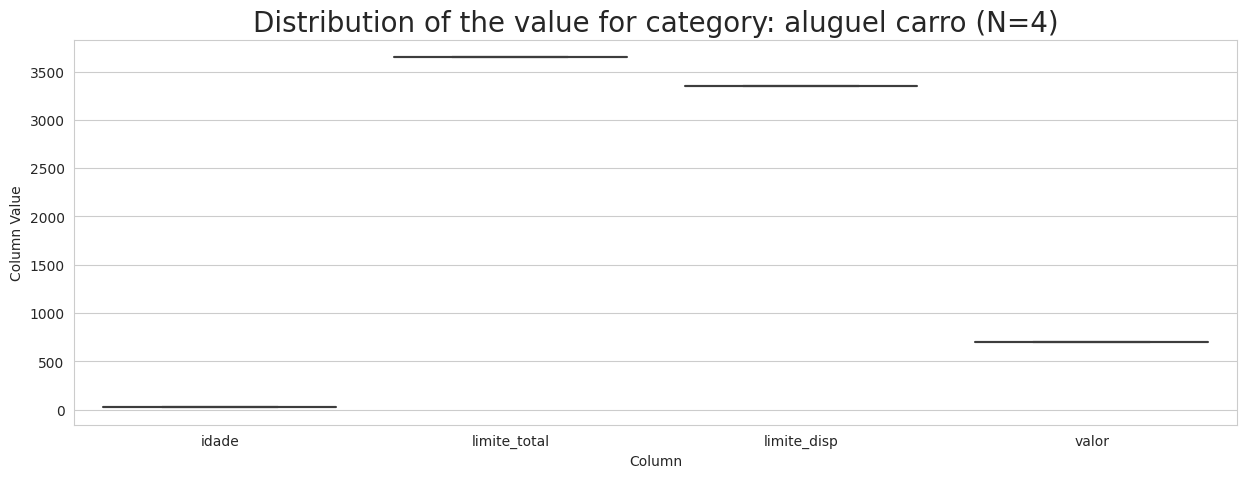

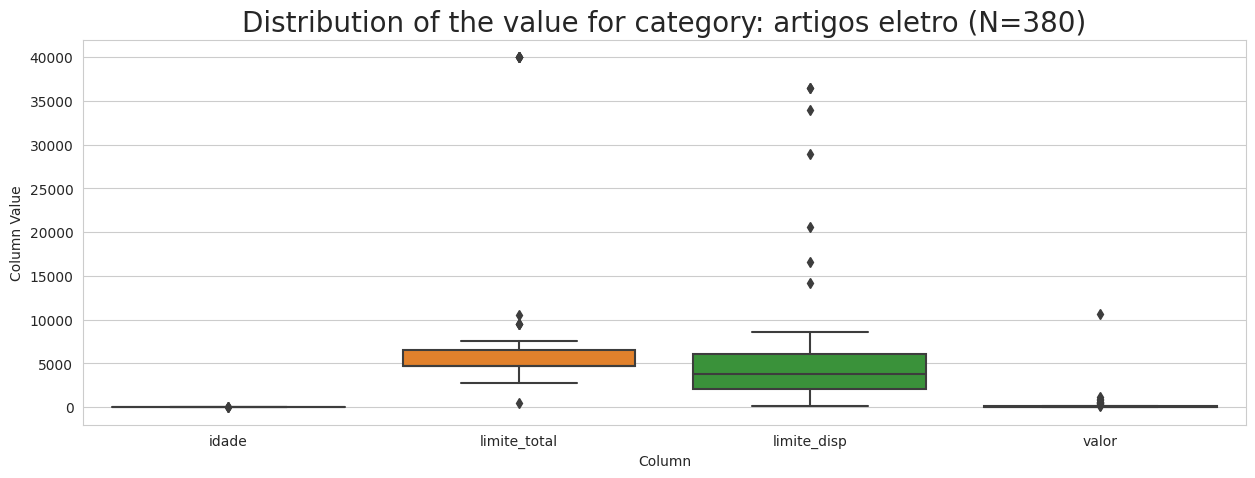

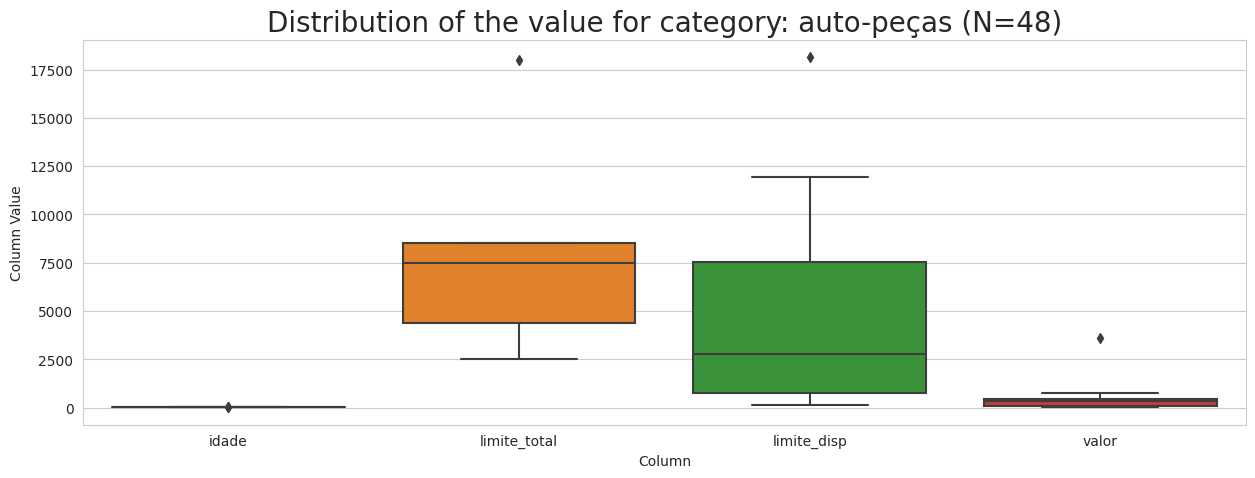

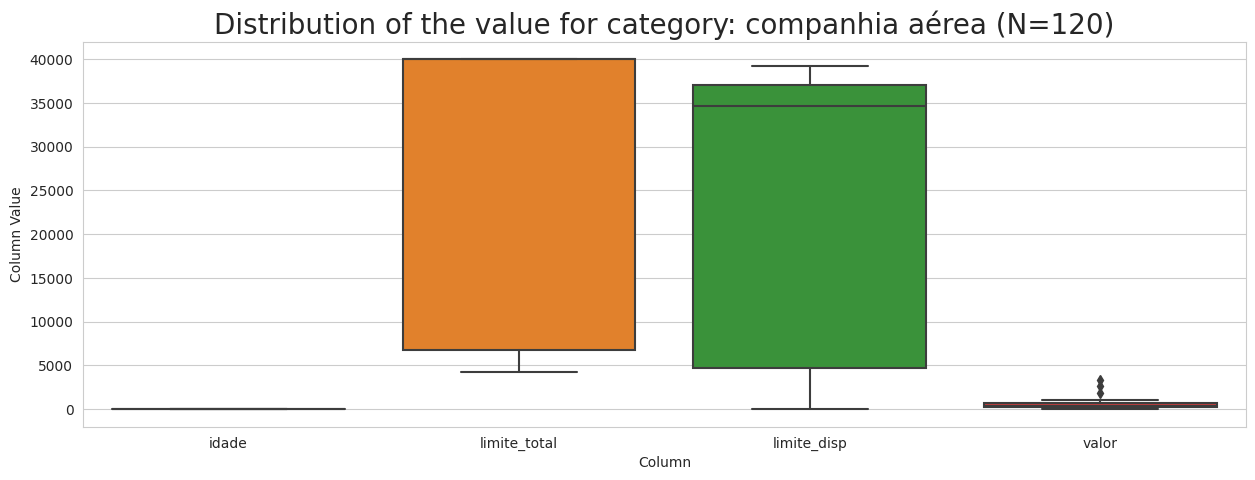

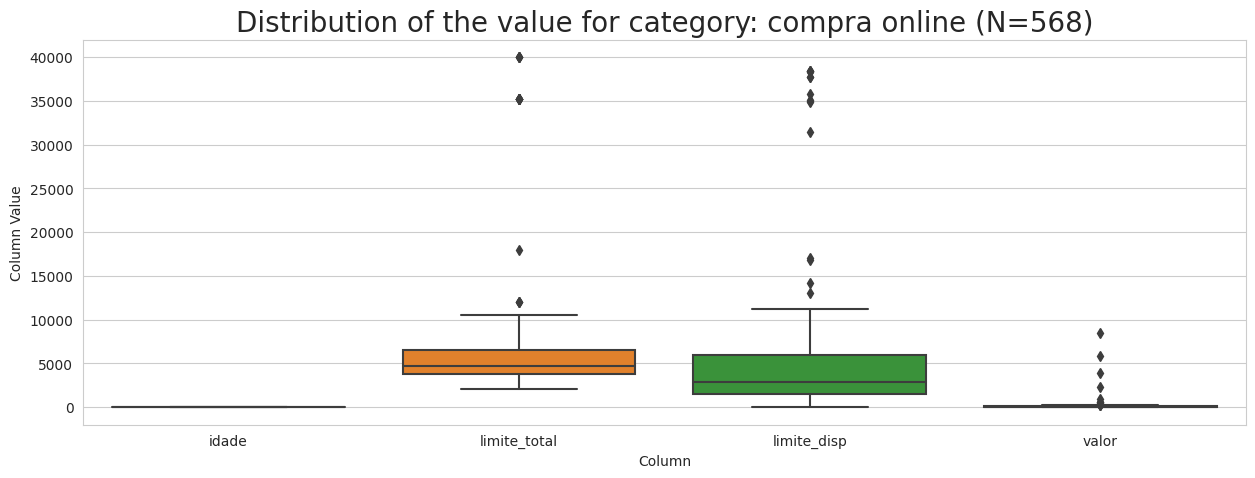

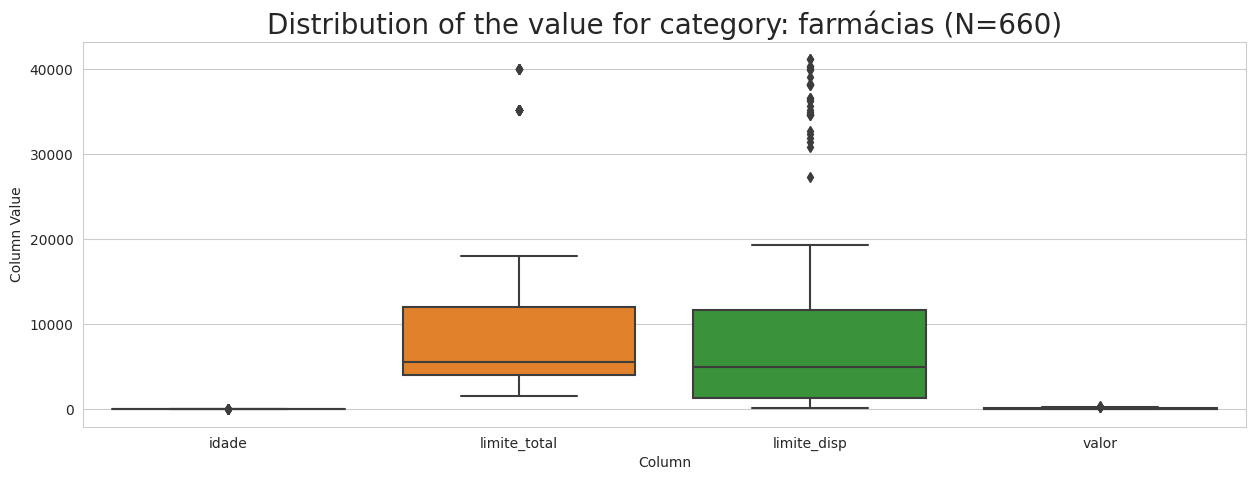

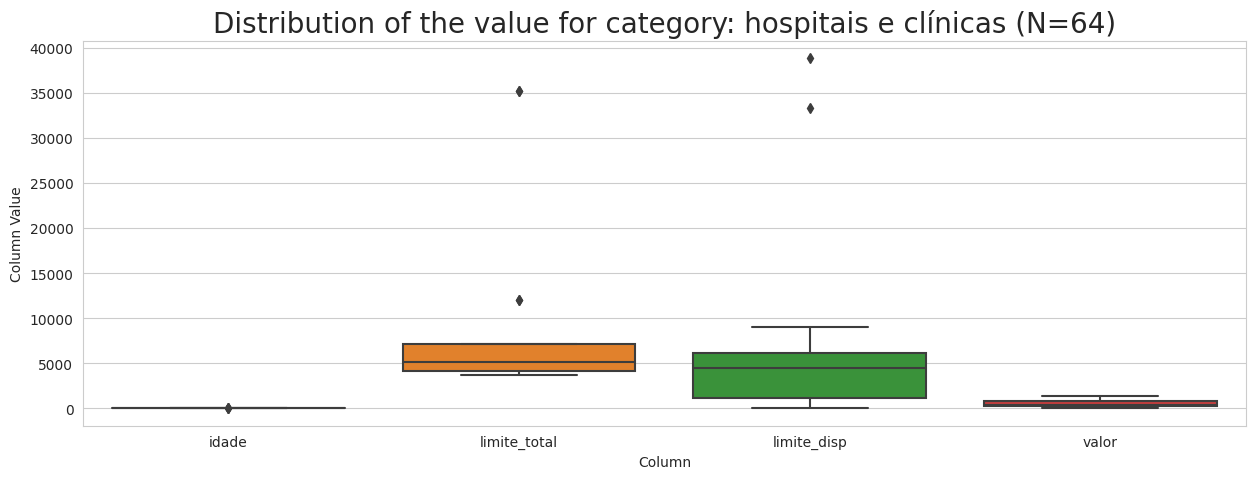

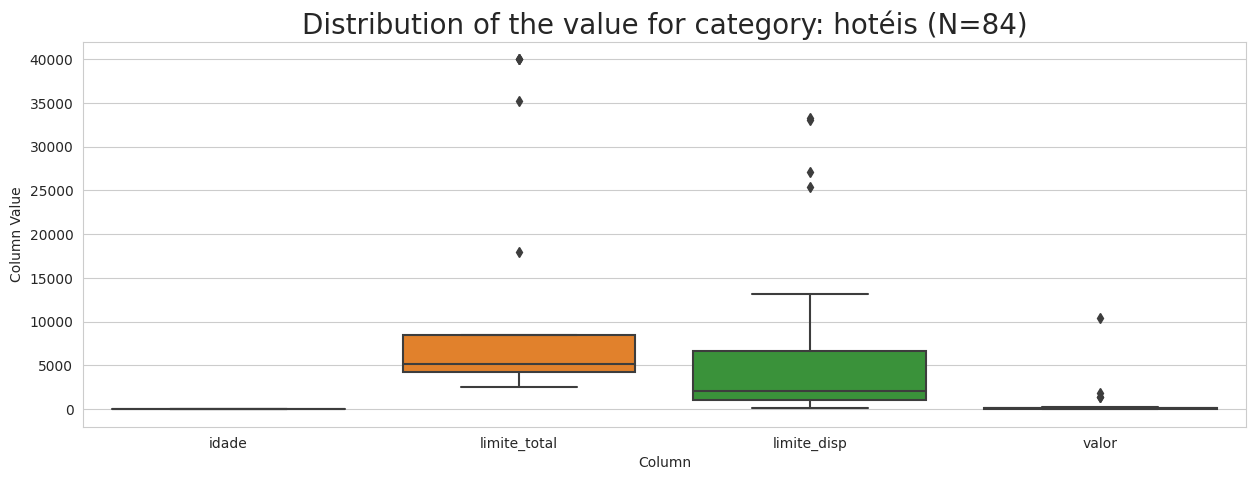

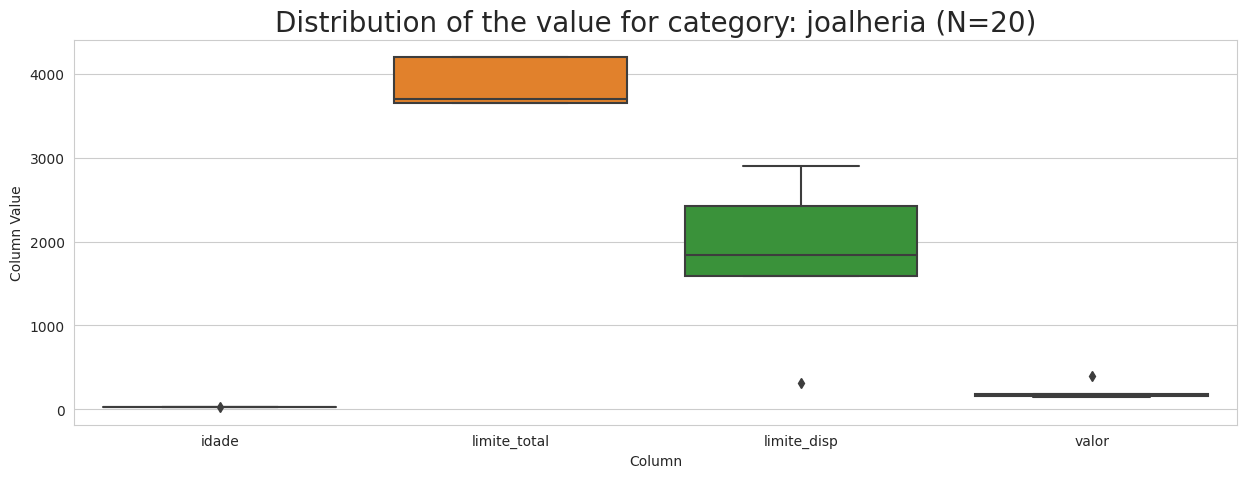

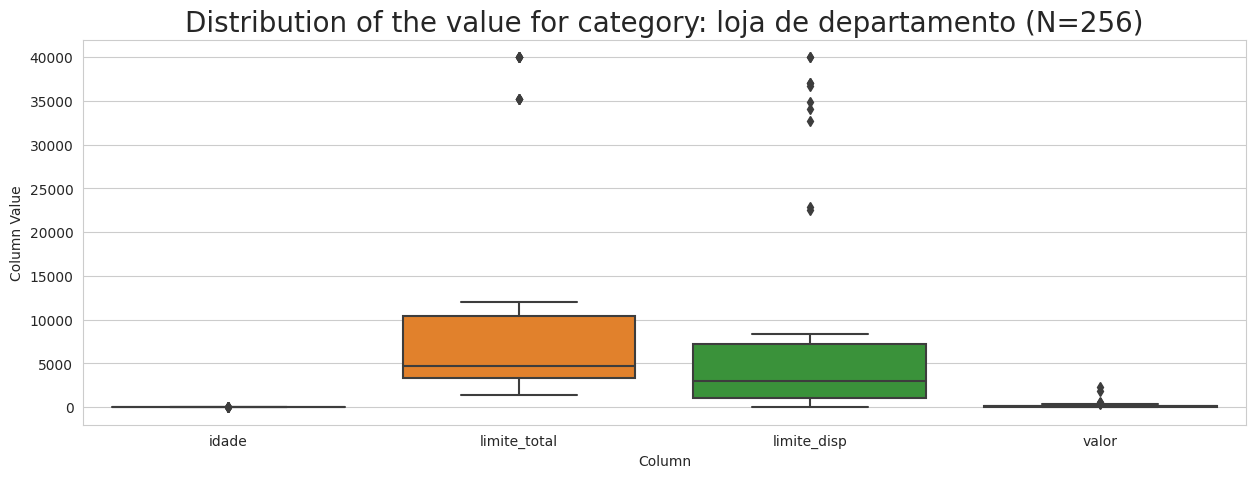

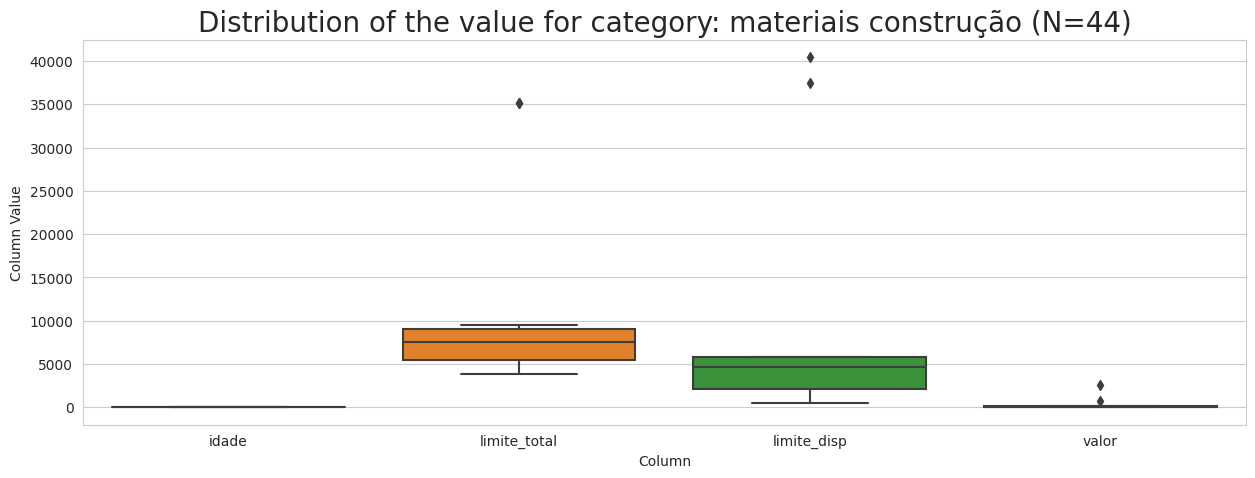

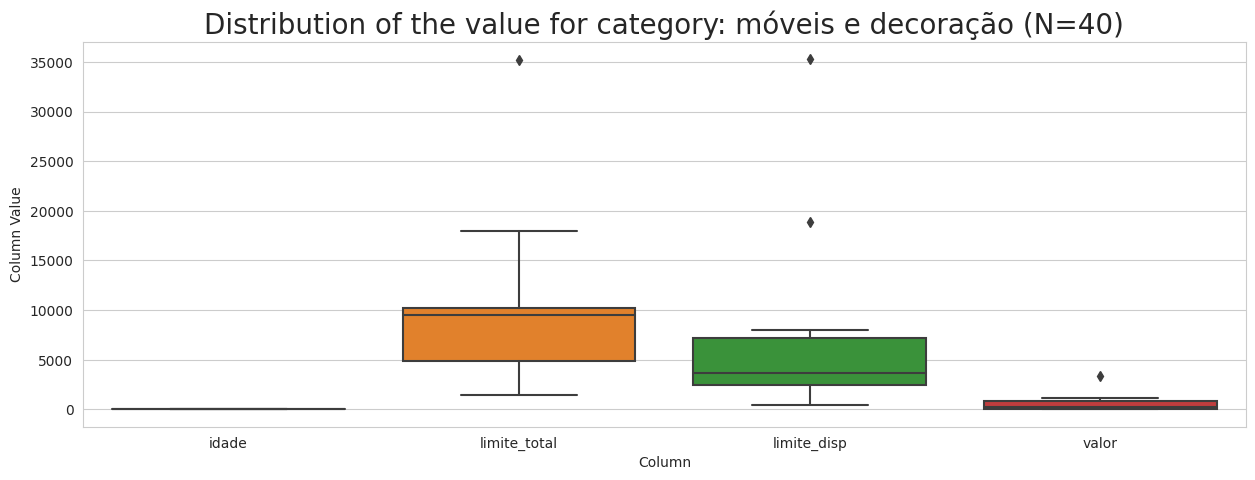

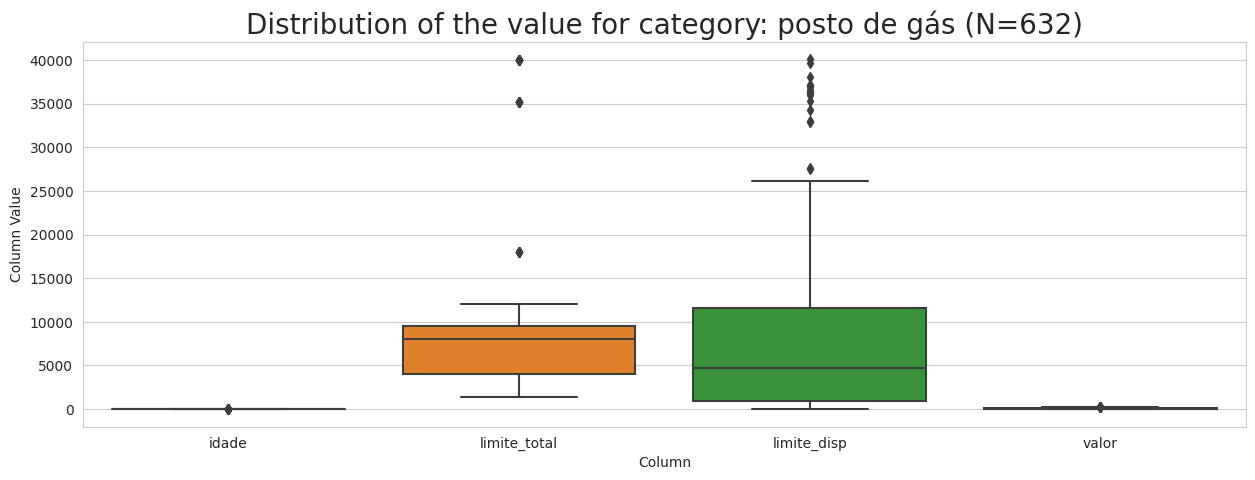

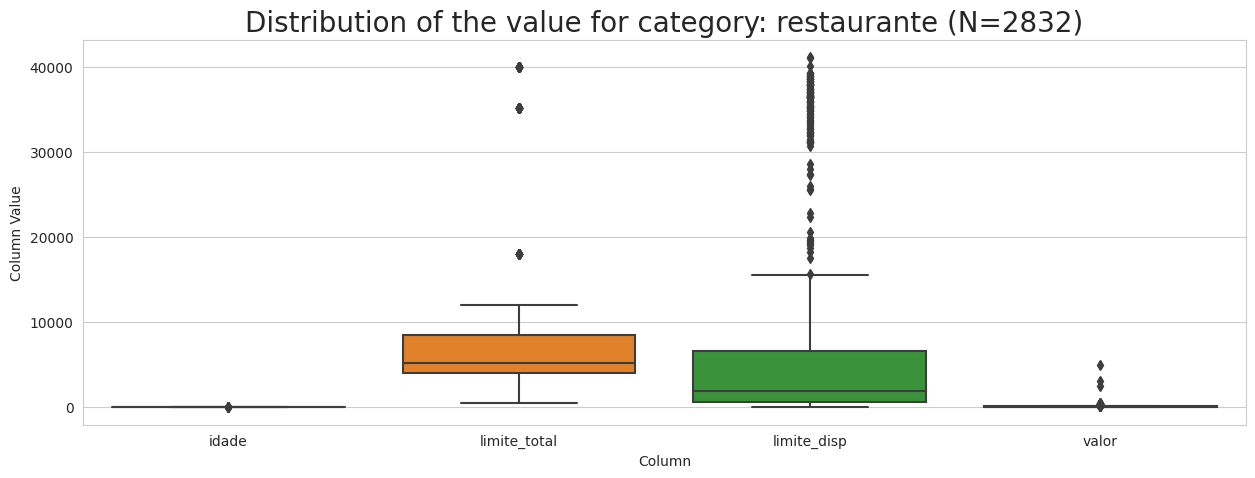

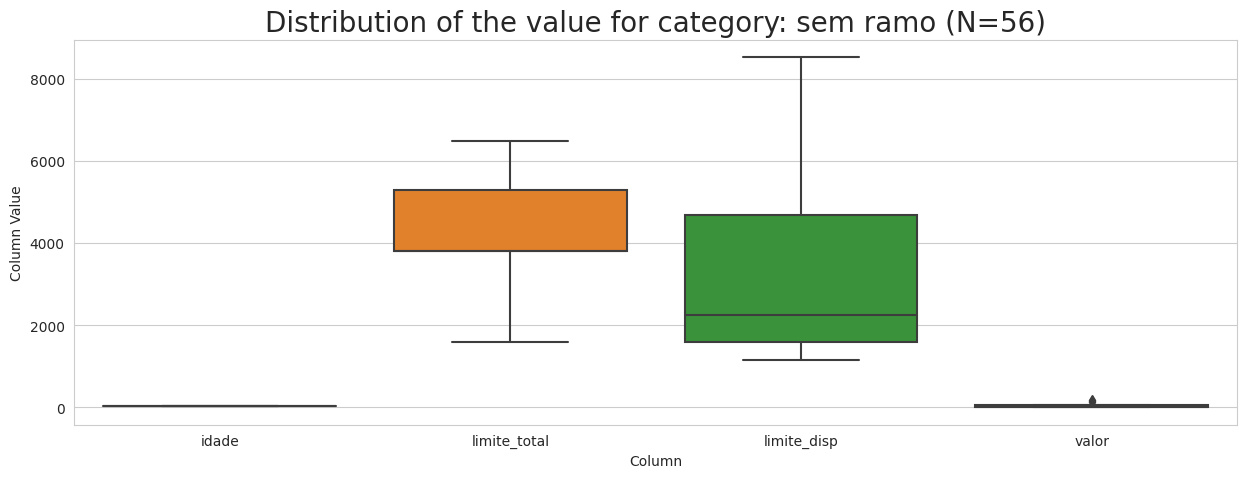

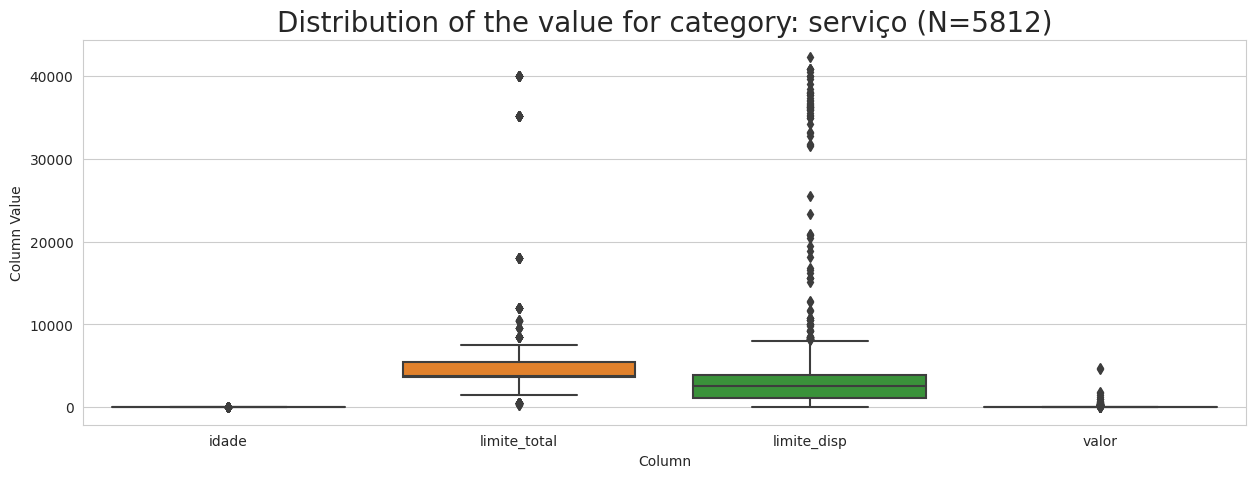

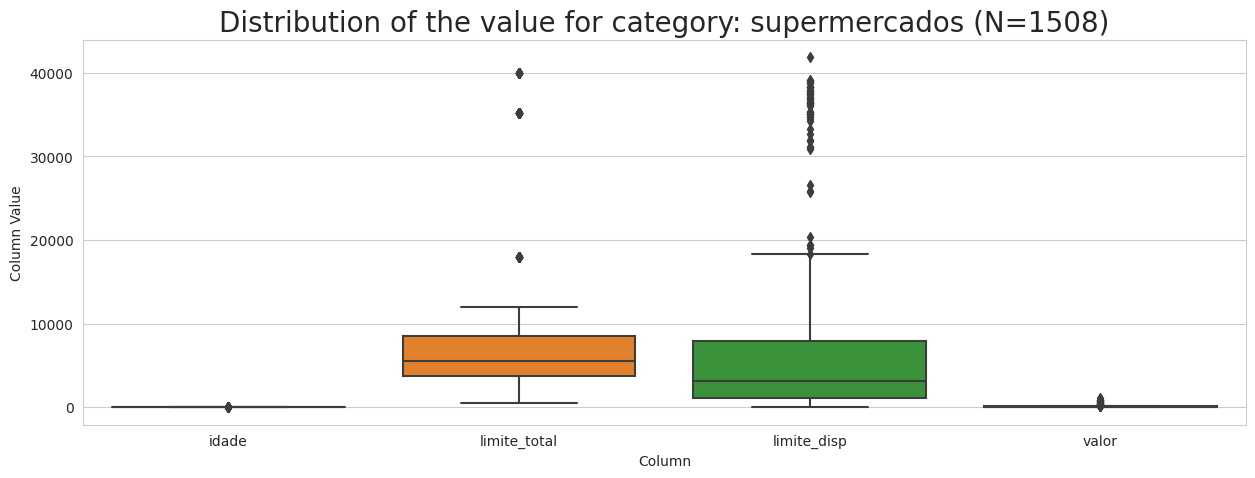

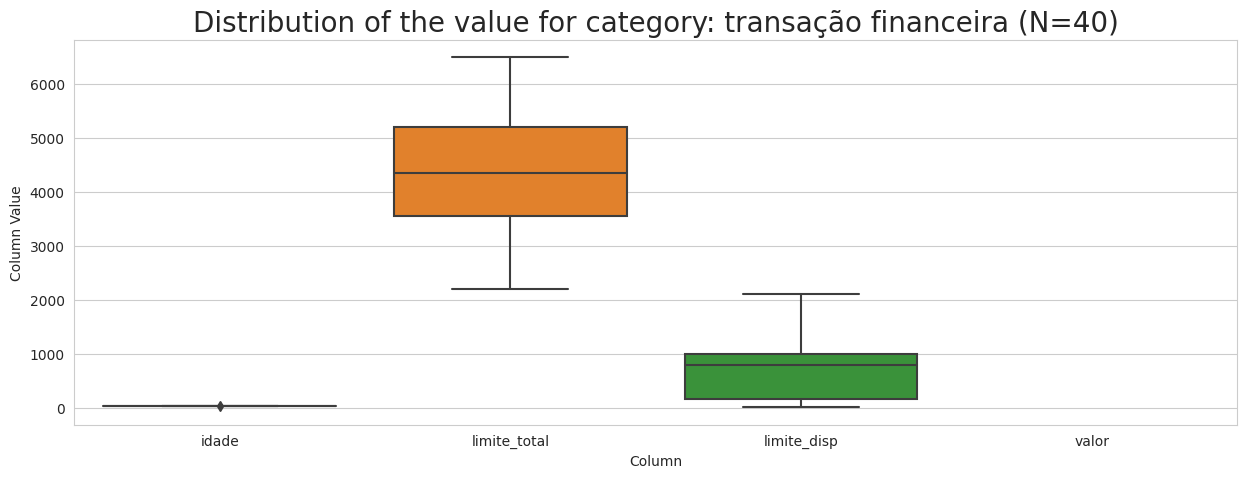

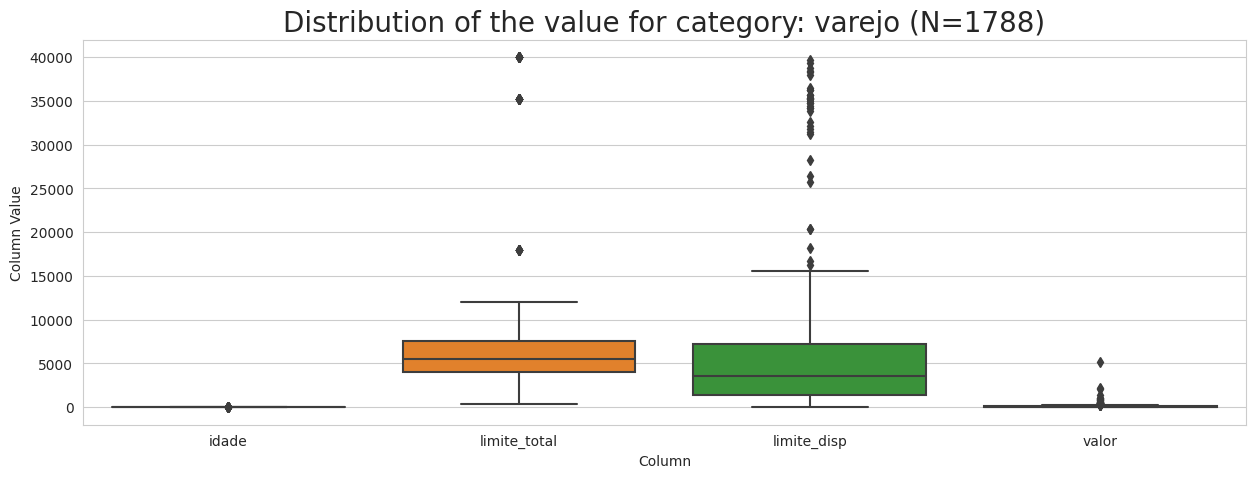

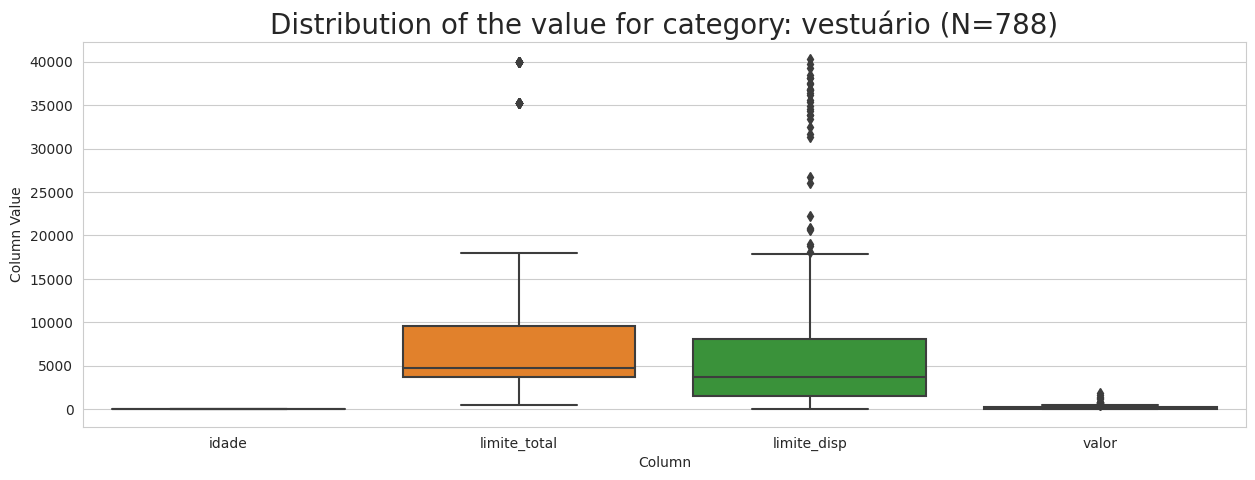

In [13]:
numeric_columns_selection = [c for c in NUMERIC_COLUMNS if c != 'safra_abertura']

view_df = (
    df
    [['grupo_estabelecimento'] + numeric_columns_selection]
    .melt(id_vars='grupo_estabelecimento', value_vars=numeric_columns_selection)
)

categories = sorted(view_df['grupo_estabelecimento'].unique().tolist())

for category in categories: 
    sliced_view_df = view_df.loc[lambda f: f['grupo_estabelecimento'] == category]
    plt.figure(figsize=(15,5))
    ax = sns.boxplot(x='variable', y='value', data=sliced_view_df)
    ax.set_title(f'Distribution of the value for category: {category} (N={len(sliced_view_df)})',
                 fontdict={'fontsize':20})
    ax.set_xlabel("Column")
    ax.set_ylabel("Column Value")
    plt.show()

#### Distribution by Time

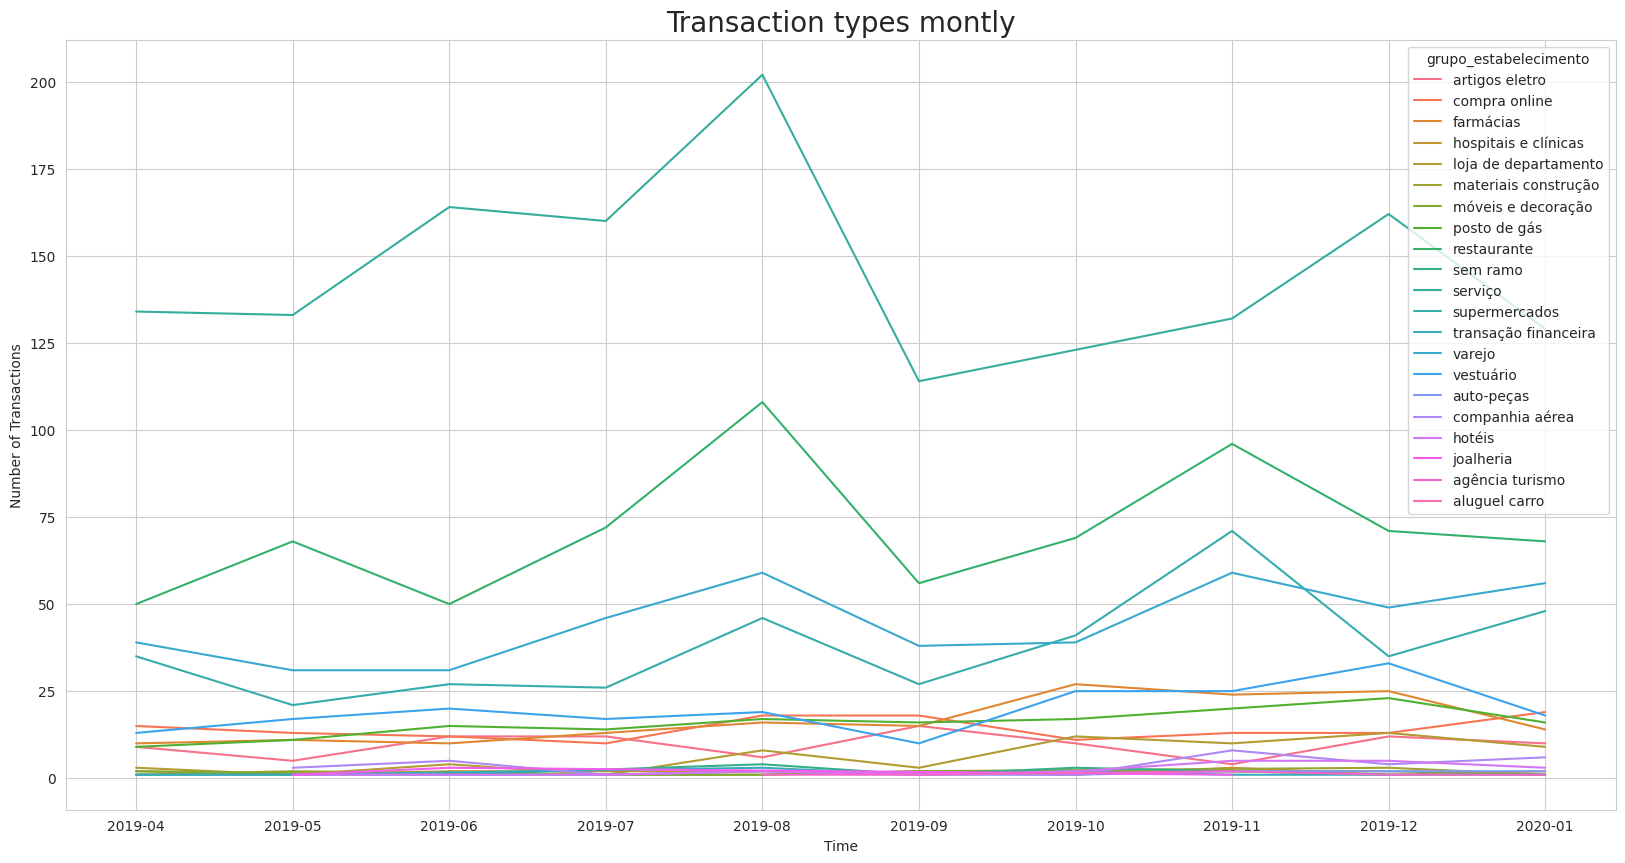

In [14]:
view_df = (
    df
    .assign(period=lambda f: f['period'].str.slice(0, 7))
    [['period', 'grupo_estabelecimento']]
    .assign(records=1)
    .groupby(['period', 'grupo_estabelecimento'])
    .sum()
    .reset_index()
)

plt.figure(figsize=(20,10))
ax = sns.lineplot(x='period', y='records', hue='grupo_estabelecimento', data=view_df)
ax.set_title(f'Transaction types montly',
             fontdict={'fontsize':20})
ax.set_xlabel("Time")
ax.set_ylabel("Number of Transactions")
plt.show()

#### Median Value Distribution by Time

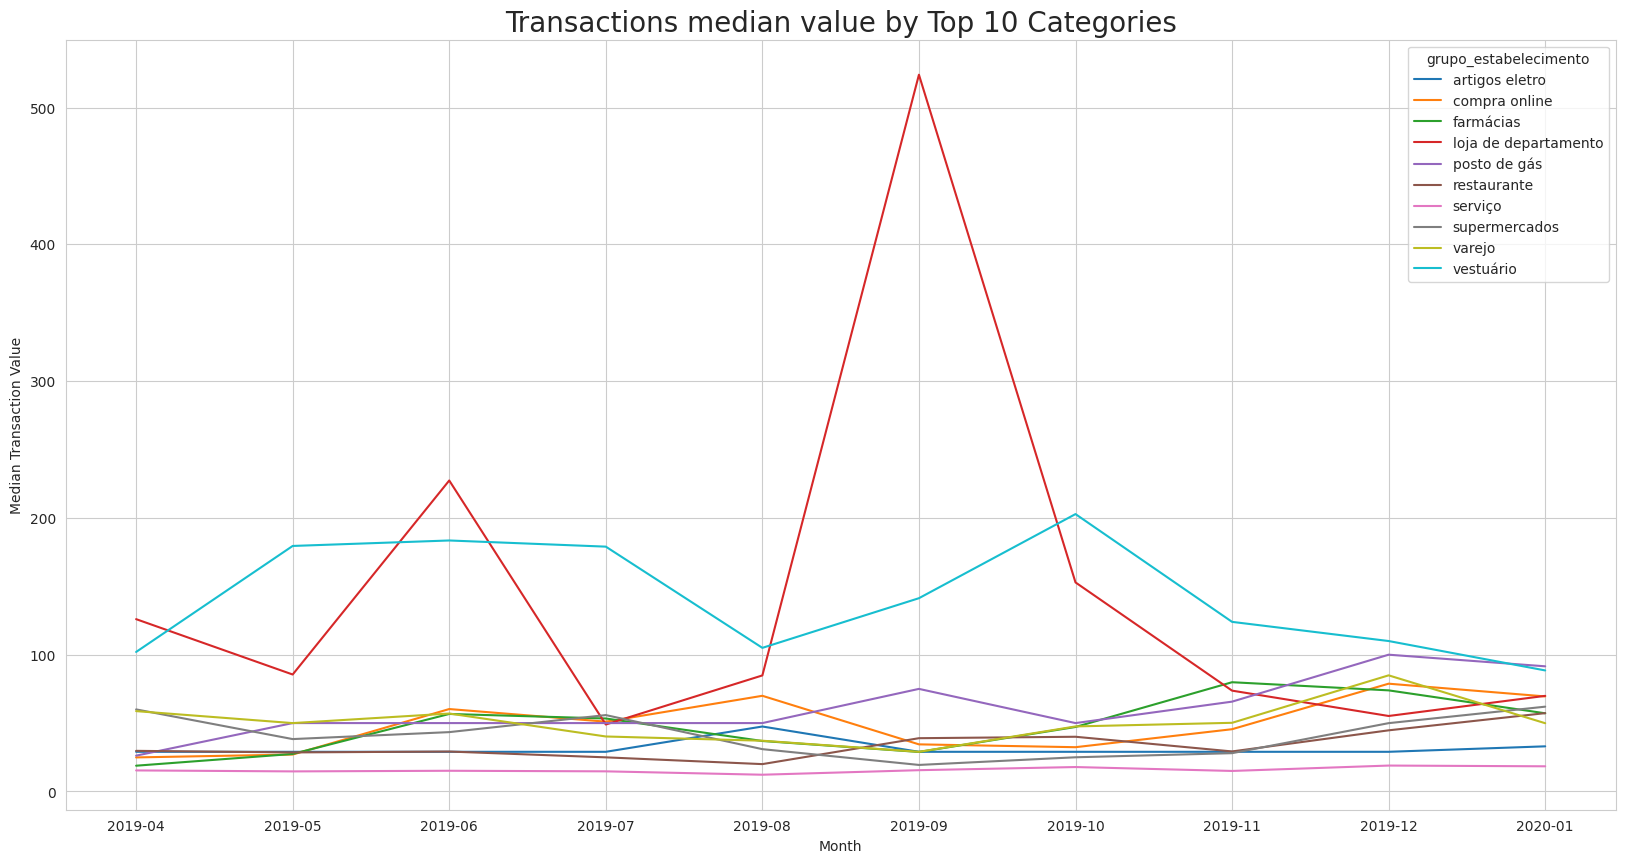

In [15]:
top_10_categories = set(labels_records_df.head(10)['grupo_estabelecimento'].tolist())

view_df = (
    df
    .assign(period=lambda f: f['period'].str.slice(0, 7))
    .loc[lambda f: f['grupo_estabelecimento'].isin(top_10_categories)]
    [['period', 'grupo_estabelecimento', 'valor']]
    .groupby(['period', 'grupo_estabelecimento'])
    .median()
    .reset_index()
    .sort_values(by=['period', 'grupo_estabelecimento'])
)

plt.figure(figsize=(20,10))
ax = sns.lineplot(x='period', y='valor', hue='grupo_estabelecimento', data=view_df)
ax.set_title(f'Transactions median value by Top 10 Categories',
             fontdict={'fontsize':20})
ax.set_xlabel("Month")
ax.set_ylabel("Median Transaction Value")
plt.show()

The high values related to `loja de departamento` seem to happen due to the low number of records related to the category, as presented below. As the dataset has a limited number of data and users, some distinct behaviors might happen often.

In [16]:
(
    df
    .loc[lambda f: f['grupo_estabelecimento'].isin(top_10_categories)]
    [['period', 'grupo_estabelecimento', 'valor']]
    .assign(period=lambda f: f['period'].str.slice(0, 7))
    .assign(records=1)
    .groupby(['period', 'grupo_estabelecimento'])
    .agg({'valor': np.median, 
          'records': np.sum})
    .sort_values(by='valor', ascending=False)
    .head(10)
)

,,valor,records
period,grupo_estabelecimento,,
2019-09,loja de departamento,524.020,3
2019-06,loja de departamento,227.360,4
2019-10,vestuário,202.800,25
2019-06,vestuário,183.500,20
2019-05,vestuário,179.500,17
2019-07,vestuário,179.000,17
2019-10,loja de departamento,152.835,12
2019-09,vestuário,141.300,10
2019-04,loja de departamento,125.990,3


It is relevant to observe that the dataset split isolated at the training set the records before the pandemic. The test set will have the influence on the pattern change.

## Feature Engineering

Some functions were created to derive new features from the available columns. The features created were:
 
 - `estado_estabelecimento`: Infers the establishment state from the establishment city using users' cities and states.
 - `cidade_diferente`: Indicate if user city is different from establishment city (might indicate a travel).
 - `estado_diferente`: Indicate if user state is different from establishment state (might indicate a travel).
 - `pais_diferente`: Indicate if user country is different from establishment state (might indicate a travel).
 - `dia_semana`: Extract the weekday from the date (might provide information about the type of transaction).
 - `dia_mes`: Extract the month day from the date (might provide information about the type of transaction).
 - `mes`: Extract the month from the date (might provide information about the type of transaction).
 - `dia_util`: Indicates if its a working day (based only on week day, not on holidays).
 - `total_relative_value`: Indicate the percentage of the value from the total value.
 - `available_relative_value`: Indicate the percentage of the value from the available value.

In [17]:
display(HTML('<h3>Sample of Derived Features Created</h3>'))
(
    df
    .sample(5)
    .pipe(engineer_features)
    .T
)

,2547,285,2437,3846,2805
id,"8,14e+11","5,91e+11","5,87e+11","2,21e+11","2,21e+11"
safra_abertura,201705,201508,201612,201311,201311
cidade,sao paulo,osasco,sao paulo,rio de janeiro,rio de janeiro
estado,sp,sp,sp,rj,rj
idade,28,35,30,45,45
sexo,False,True,True,False,False
limite_total,4700,5500,4700,35200,35200
limite_disp,4230,5557,5220,32253,38407
data,24.08.2019,11.07.2019,7.01.2020,9.11.2019,8.09.2019
valor,7.9,36.0,24.11,416.4,1.0


There are some other potential features that could be used, but would require some additional efforts:
 - Some time window based features:
     - Average value of last transactions.
     - Number of transactions on the last `n` days.
     - Average number of different cities on the last transactions.
 - Demographic information about user and establishment cities.
 - In addition to knowing if users' city/state/country are different from establishments', it would be possible to compute the distance between them.
 - User cluster, considering expenses, age, gender, etc.
 - Identify holidays and special dates based on location and public calendars.
 
 Aditionally, there are some features, not available in this dataset, that could provide relevant information, such as:
  - `establishment identification`:
      - `common transactions`: Knowing the establishment would probably allow to define one or a few transaction types.
      - `buying recurrence`: It would be possible to understand how often people perform a transaction at each establishment.
      - `transactions count`: The number of transactions per day or hour could also reveal relevant information.
  - `time`: The transaction hour could also help providing more patterns for each category.

## Concluding Remarks

The main findings were:
 - There are 2 duplicated records that should be elimiated before the training.
 - There are some missing and missplacing values that degrades the dataset quality. The number of issues is not excessive, but I might require some additional treatments when performing production/test predictions.
 - Some additional features were derived based on location, date, limits and values.
 - As the new features were created and there are some quality issues, it might be relevant to perform a feature importance analysis.
 - The dataset is highly unbalanced and have 11 labels with less than 1% of the dataset size.
 - The dataset split might cause the training set to contain pre-pandemic while and the test set with pandemic data. The pattern shift might be an additional challenge to the categorization prediction.
 
## Future Activities

Some additional possibilities are:
 - Compute features correlation.
 - Analyze the history of some users to identify new possible features and patterns.
 - Analyze the transaction types along time.